## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/tobigs/week6/NN advanced/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/tobigs/week6/NN advanced/Test.csv')

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train['label'].nunique()

10

In [5]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

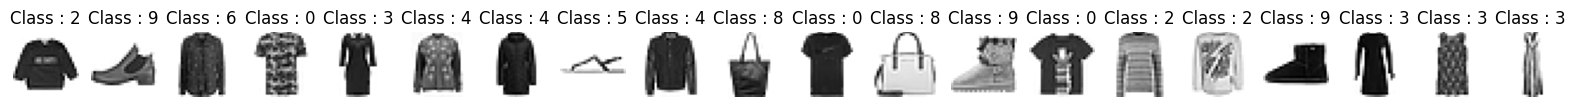

In [7]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [8]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

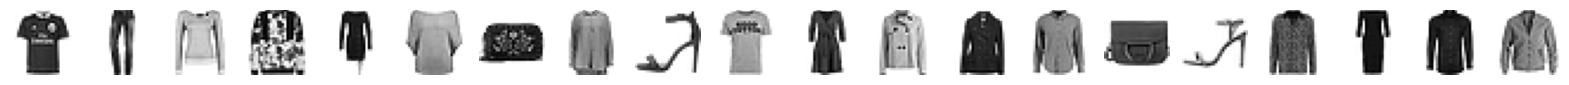

In [9]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [11]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [12]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [13]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [18]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [19]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [21]:
class MyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.bn1 = nn.BatchNorm1d(num_features=512)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.bn4 = nn.BatchNorm1d(num_features=64)
        self.bn5 = nn.BatchNorm1d(num_features=32)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)

        x = x.float()
        x = self.relu(self.bn1(self.fc1(x.view(-1, 784))))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)
model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

In [ ]:
class MyNet_witoutinitalize(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.bn1 = nn.BatchNorm1d(num_features=512)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.bn4 = nn.BatchNorm1d(num_features=64)
        self.bn5 = nn.BatchNorm1d(num_features=32)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)

        x = x.float()
        x = self.relu(self.bn1(self.fc1(x.view(-1, 784))))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)
model = MyNet_witoutinitalize().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.6326, 	Train Accuracy: 82.48 %, 	Val Loss: 0.4146, 	Val Accuracy: 85.88 % 

[EPOCH: 2], 	Train Loss: 0.3734, 	Train Accuracy: 86.96 %, 	Val Loss: 0.3557, 	Val Accuracy: 87.35 % 

[EPOCH: 3], 	Train Loss: 0.3262, 	Train Accuracy: 88.19 %, 	Val Loss: 0.3374, 	Val Accuracy: 87.95 % 

[EPOCH: 4], 	Train Loss: 0.2986, 	Train Accuracy: 89.19 %, 	Val Loss: 0.3494, 	Val Accuracy: 87.30 % 

[EPOCH: 5], 	Train Loss: 0.2757, 	Train Accuracy: 89.93 %, 	Val Loss: 0.3369, 	Val Accuracy: 87.63 % 

[EPOCH: 6], 	Train Loss: 0.2561, 	Train Accuracy: 90.64 %, 	Val Loss: 0.3501, 	Val Accuracy: 86.92 % 

[EPOCH: 7], 	Train Loss: 0.2422, 	Train Accuracy: 91.10 %, 	Val Loss: 0.3426, 	Val Accuracy: 87.63 % 

[EPOCH: 8], 	Train Loss: 0.2281, 	Train Accuracy: 91.64 %, 	Val Loss: 0.3286, 	Val Accuracy: 88.33 % 

[EPOCH: 9], 	Train Loss: 0.2081, 	Train Accuracy: 92.34 %, 	Val Loss: 0.3334, 	Val Accuracy: 87.80 % 

[EPOCH: 10], 	Train Loss: 0.1968, 	Train Accuracy: 92.69 %, 	Val Loss: 0.

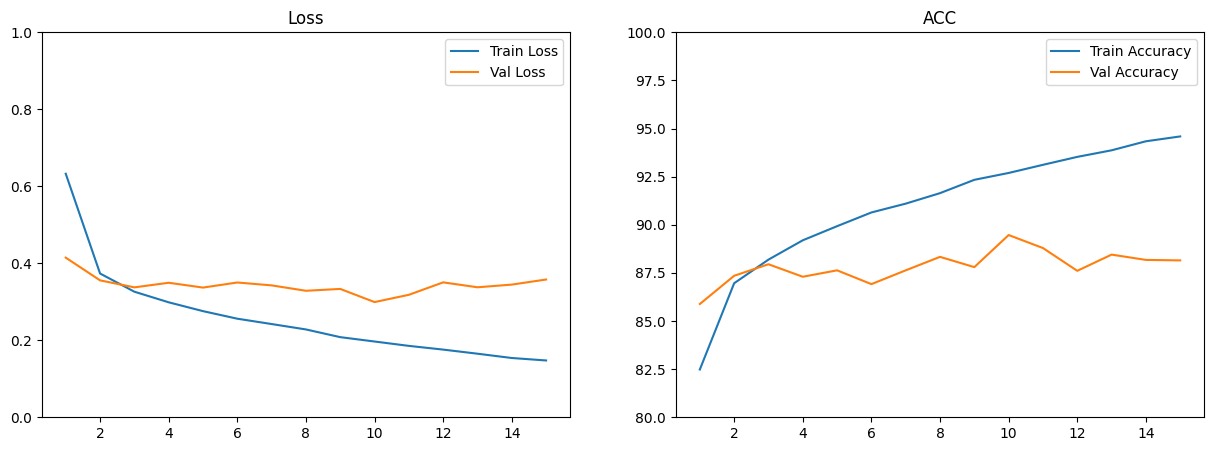

In [20]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

[EPOCH: 1], 	Train Loss: 0.5391, 	Train Accuracy: 82.68 %, 	Val Loss: 0.3905, 	Val Accuracy: 86.32 % 

[EPOCH: 2], 	Train Loss: 0.3604, 	Train Accuracy: 87.09 %, 	Val Loss: 0.3794, 	Val Accuracy: 85.82 % 

[EPOCH: 3], 	Train Loss: 0.3127, 	Train Accuracy: 88.54 %, 	Val Loss: 0.3593, 	Val Accuracy: 86.92 % 

[EPOCH: 4], 	Train Loss: 0.2878, 	Train Accuracy: 89.37 %, 	Val Loss: 0.3413, 	Val Accuracy: 87.47 % 

[EPOCH: 5], 	Train Loss: 0.2601, 	Train Accuracy: 90.34 %, 	Val Loss: 0.3248, 	Val Accuracy: 88.29 % 

[EPOCH: 6], 	Train Loss: 0.2446, 	Train Accuracy: 90.93 %, 	Val Loss: 0.3293, 	Val Accuracy: 87.79 % 

[EPOCH: 7], 	Train Loss: 0.2282, 	Train Accuracy: 91.54 %, 	Val Loss: 0.3259, 	Val Accuracy: 88.20 % 

[EPOCH: 8], 	Train Loss: 0.2115, 	Train Accuracy: 92.16 %, 	Val Loss: 0.3296, 	Val Accuracy: 88.60 % 

[EPOCH: 9], 	Train Loss: 0.1961, 	Train Accuracy: 92.76 %, 	Val Loss: 0.3408, 	Val Accuracy: 88.38 % 

[EPOCH: 10], 	Train Loss: 0.1871, 	Train Accuracy: 93.07 %, 	Val Loss: 0.

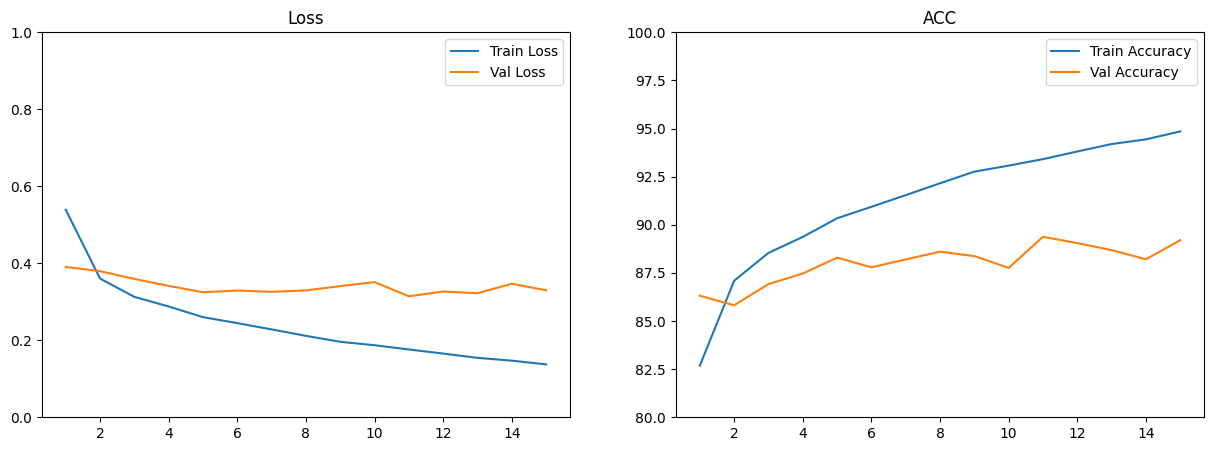

In [22]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

In [ ]:
'''
NN 모델을 Dropout 적용 없이 batchnoramlization을 적용하고 / 가중치 초기화 방법을 통해 모델을 생성하였다.
옵티마이저로 Adam을 사용하였고  LeakyRELU를 이용하였따.

가중치 초기화를 적용하였을때 조금 더 높은 val accuracy를 보여주었지만 드라마틱하게 높은 결과를
보여주진 않았다.
'''